In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.apcemm import APCEMM
from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core import met_var, GeoVectorDataset, models, vector
from pycontrails.physics import constants, thermo, units
from pycontrails.datalib.ecmwf import ERA5ARCO

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.dry_advection import DryAdvection
from pycontrails.models.humidity_scaling import ConstantHumidityScaling

plt.rcParams["figure.figsize"] = (10, 6)

In [70]:
time_bounds = ("2022-03-01 00:00:00", "2022-03-01 12:00:00")
pressure_levels = (300, 250, 200)

era5pl = ERA5(
    time=time_bounds,
    variables=Cocip.met_variables + Cocip.optional_met_variables + APCEMM.met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time_bounds, variables=Cocip.rad_variables)

met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

In [71]:
flight_attrs = {
    "flight_id": "test",
    # set constants along flight path
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,  # non-volatile emissions index
    "aircraft_type": "E190",
    "wingspan": 48,  # m
    "n_engine": 2,
}

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(-25, -25, 1)
df["latitude"] = np.linspace(30, 30, 1)
df["altitude"] = np.linspace(10900, 10900, 1)
df["engine_efficiency"] = np.linspace(0.34, 0.34, 1)
df["fuel_flow"] = np.linspace(2.1, 2.1, 1)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154445, 1)  # kg
df["time"] = pd.date_range("2022-03-01T00:15:00", "2022-03-01T02:30:00", periods=1)

fl = Flight(df, attrs=flight_attrs)

In [72]:
dt_integration = pd.Timedelta(minutes=2)
max_age = pd.Timedelta(hours=6)

params = {
    "dt_integration": dt_integration,
    "max_age": max_age,
    "depth": 0.0,  # initial plume depth, [m]
    "width": 0.0,  # initial plume width, [m]
}
dry_adv = DryAdvection(met, params)
dry_adv_df = dry_adv.eval(fl).dataframe

/usr/local/lib/python3.10/site-packages/pycontrails/models/cocip/contrail_properties.py:664: RuntimeWarning: invalid value encountered in divide
  return area_eff / width


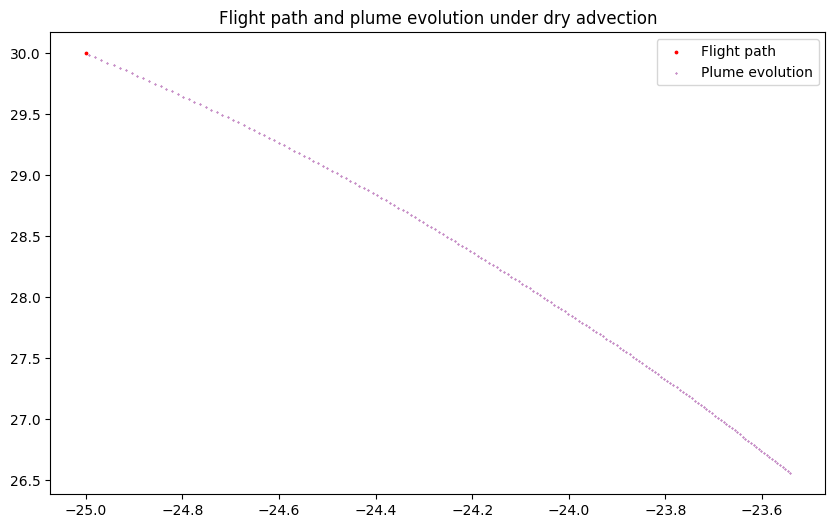

In [73]:
ax = plt.axes()

ax.scatter(fl["longitude"], fl["latitude"], s=3, color="red", label="Flight path")
ax.scatter(
    dry_adv_df["longitude"], dry_adv_df["latitude"], s=0.1, color="purple", label="Plume evolution"
)
ax.legend()
ax.set_title("Flight path and plume evolution under dry advection");

In [74]:
v_wind = dry_adv_df["v_wind"].values
level = dry_adv_df["level"].values
time = dry_adv_df["time"].values
vertical_velocity = dry_adv_df["vertical_velocity"].values
air_pressure = dry_adv_df["air_pressure"].values
air_temperature = dry_adv_df["air_temperature"].values
lon = dry_adv_df["longitude"].values
age = dry_adv_df["age"].values
u_wind = dry_adv_df["u_wind"].values
lat = dry_adv_df["latitude"].values
azimuth = dry_adv_df["azimuth"].values
depth = dry_adv_df["depth"].values

In [75]:
# _gen_apcemm_nc

n_profiles = 180
dt_input_met = np.timedelta64(6, "m")

# APCEMM requires atmospheric profiles at even time intervals. 
# We must therefore interpolate horizontal location and azimuth 
# to an evenly spaced set of time coordinates

tick = np.timedelta64(6, "m")
target_elapsed = np.linspace(0, n_profiles-1 * dt_input_met / tick, n_profiles)
target_time = time[0] + target_elapsed * tick
elapsed = (time - time[0]) / tick

# Need to deal with crossing the antimeridian. Once detecting the corssing,
# we covert longitudes to [0, 360) before interpolating flights that cross 
# the antimeridian and un-convert any longitudes above 180 degrees after

min_pos = np.min(lon[lon>0], initial = np.inf)
max_neg = np.max(lon[lon<0], initial=-np.inf)
if (180 - min_pos) + (180 + max_neg) < 180 and min_pos < np.inf and max_neg > -np.inf:
    lon = np.where(lon > 0, lon - 360, lon)
interp_lon = np.interp(target_elapsed, elapsed, lon)
interp_lon = np.where(interp_lon > 180, interp_lon - 360, interp_lon)

interp_lat = np.interp(target_elapsed, elapsed, lat)
interp_az = np.interp(target_elapsed, elapsed, azimuth)

altitude = met["altitude"].values

In [76]:
time = target_time
lon = interp_lon
lat = interp_lat
azimuth = interp_az
altitude = altitude
humidity_scaling = None
dz_m = 200

In [77]:
def normal_wind_shear(u_hi,u_lo, v_hi,v_lo,azimuth,dz: float):    
    du_dz = (u_hi - u_lo) / dz
    dv_dz = (v_hi - v_lo) / dz
    az_radians = units.degrees_to_radians(azimuth)
    sin_az = np.sin(az_radians)
    cos_az = np.cos(az_radians)
    return sin_az * dv_dz - cos_az * du_dz

In [78]:
# generate_apcemm_input_met

# Ensure that altitudes are sorted ascending
altitude = np.sort(altitude)

# Check for required fields in met
vars = (met_var.AirTemperature,
        met_var.SpecificHumidity,
        met_var.Geopotential,
        met_var.EastwardWind,
        met_var.NorthwardWind,
        met_var.VerticalVelocity)

met.ensure_vars(vars)
met.standardize_variables(vars)

# Flatten input arrays
time = time.ravel()
lon = lon.ravel()
lat = lat.ravel()
azimuth = azimuth.ravel()
altitude = altitude.ravel()

# Estimate pressure levels close to target altitudes
# (not exact because this assumes the ISA temperature profile)
pressure = units.m_to_pl(altitude) #* 1e2

# Broadcast to required shape and create vector for intial interpolation
# onto original pressure levels at target horizontal location
shape = (time.size, altitude.size)
time = np.broadcast_to(time[:, np.newaxis], shape).ravel()
lon = np.broadcast_to(lon[:, np.newaxis], shape).ravel()
lat = np.broadcast_to(lat[:, np.newaxis], shape).ravel()
azimuth = np.broadcast_to(azimuth[:, np.newaxis], shape).ravel()
level = np.broadcast_to(level[:, np.newaxis], shape).ravel()

vector = GeoVectorDataset(data = {"azimuth": azimuth}, longitude=lon, latitude=lat, level=level, time=time)

# Downselect met beofre interpolation
met = vector.downselect_met(met)

# Interpolate meterology data onto vector
scale_humidity = humidity_scaling is not None and "specfic_humidity" not in vector
for met_key in (
        "air_temperature",
        "eastward_wind",
        "geopotential",
        "northward_wind",
        "specific_humidity",
        "lagrangian_tendency_of_air_pressure",
    ):
        models.interpolate_met(met, vector, met_key, None)



In [113]:

print(vector["longitude"][118*3])
print(vector["latitude"][118*3])
print(vector["level"][118*3])
print(vector["time"][118*3])
print(vector["air_temperature"][118*3])

-23.54181729910988
26.557588495003085
233.72951976702035
2022-03-01T12:04:00.000000000
nan


In [115]:
#print(vector["longitude"][-10:-1])

print(met)
print(met['level'])


mda = met["air_temperature"]

from datetime import datetime

# longitude, latitude, level, time

mda.interpolate(-23.54181729910988,26.557588495003085,233.72951976702035,np.datetime64('2022-03-01T12:04:00.000000000'))

# longitude from -25 to -23.5
# latitude from 26.5 to 30
# level from 200 to 250


MetDataset with data:

<xarray.Dataset>
Dimensions:                              (longitude: 7, latitude: 15, level: 2,
                                          time: 13)
Coordinates:
    number                               int64 0
  * time                                 (time) datetime64[ns] 2022-03-01 ......
  * level                                (level) float64 200.0 250.0
  * latitude                             (latitude) float64 26.5 26.75 ... 30.0
    expver                               (time) <U4 '0001' '0001' ... '0001'
  * longitude                            (longitude) float64 -25.0 ... -23.5
    air_pressure                         (level) float32 2e+04 2.5e+04
    altitude                             (level) float32 1.178e+04 1.036e+04
Data variables:
    air_temperature                      (longitude, latitude, level, time) float32 ...
    specific_humidity                    (longitude, latitude, level, time) float32 ...
    eastward_wind                        (

array([nan], dtype=float32)

In [83]:


# Interpolate winds at lower level for shear calculation
air_pressure_lower = thermo.pressure_dz(vector["air_temperature"], vector.air_pressure, dz_m)
lower_level = air_pressure_lower / 100.0
for met_key in ("eastward_wind", "northward_wind"):
        vector_key = f"{met_key}_lower"
        models.interpolate_met(met, vector, met_key, vector_key, level=lower_level)

# Apply humidity scaling
if scale_humidity and humidity_scaling is not None:
        humidity_scaling.eval(vector, copy_source=False)

# Compute RHi and segment-normal shear
vector.setdefault(
        "rhi",
        thermo.rhi(vector["specific_humidity"], vector["air_temperature"], vector.air_pressure),
)

vector.setdefault(
        "normal_shear",
        normal_wind_shear(
                vector["eastward_wind"],
                vector["eastward_wind_lower"],
                vector["northward_wind"],
                vector["northward_wind_lower"],
                vector["azimuth"],
                dz_m,            
        ),
)

# Reshape interpolated fields to (time, level)

nlev = altitude.size
ntime = len(vector) // nlev
shape = (ntime, nlev)
time = np.unique(vector["time"])
time = (time - time[0]) / np.timedelta64(1, "h")
temperature = vector["air_temperature"].reshape(shape)
qv = vector["specific_humidity"].reshape(shape)
z = vector["geopotential"].reshape(shape)
rhi = vector["rhi"].reshape(shape)
shear = vector["normal_shear"].reshape(shape)
shear[:, -1] = shear[:, -2]
omega = vector["lagrangian_tendency_of_air_pressure"].reshape(shape)
virtual_temperature = temperature * (1 + qv / constants.epsilon) / (1 + qv)
density = pressure[np.newaxis, :] / (constants.R_d * virtual_temperature)
w = -omega / (density * constants.g)

# Interpolate fields to target altitudes profile-by-profile
# to obtain 2D arrays with dimensions (time, altitude)
temperature_on_z = np.zeros(shape, dtype=temperature.dtype)
rhi_on_z = np.zeros(shape, dtype=rhi.dtype)
shear_on_z = np.zeros(shape, dtype=shear.dtype)
w_on_z = np.zeros(shape, dtype=w.dtype)

# Fields should already be on pressure levels close to target
# altitudes, so this just uses linear interpolation and const.
# extrapolation on field expected by APCEMM. 
# NaNs are preserved at the start and end of interpolated
# profiles but are removed in interiors.

def interp(z: np.ndarray, z0: np.ndarray, f0: np.ndarray) -> np.ndarray:
        # mask nans
        mask = np.isnan(z0) | np.isnan(f0)
        if np.all(mask):
            msg = (
                "Found all-NaN profile during APCEMM meterology input file creation. "
                "MetDataset may have insufficient spatiotemporal coverage."
            )
            raise ValueError(msg)
        z0 = z0[~mask]
        f0 = f0[~mask]

        # interpolate
        #assert np.all(np.diff(z0) > 0)  # expect increasing altitudes
        fi = np.interp(z, z0, f0, left=f0[0], right=f0[-1])

        # restore nans at start and end of profile
        if mask[0]:  # nans at top of profile
            fi[z > z0.max()] = np.nan
        if mask[-1]:  # nans at end of profile
            fi[z < z0.min()] = np.nan
        return fi

# The manual for loop is unlikely to be a bottleneck since a
# substantial amount of work is done within each iteration.
for i in range(ntime):
        print(i)
        print(temperature[i,:])
        temperature_on_z[i, :] = interp(altitude, z[i, :], temperature[i, :])
        rhi_on_z[i, :] = interp(altitude, z[i, :], rhi[i, :])
        shear_on_z[i, :] = interp(altitude, z[i, :], shear[i, :])
        w_on_z[i, :] = interp(altitude, z[i, :], w[i, :])

# APCEMM also requires initial pressure profile
pressure_on_z = interp(altitude, z[0, :], pressure)

# Create APCEMM input dataset.
# Transpose require because APCEMM expects (altitude, time) arrays.

ds = xr.Dataset(
        data_vars={
            "pressure": (("altitude",), pressure_on_z.astype("float32") / 1e2, {"units": "hPa"}),
            "temperature": (
                ("altitude", "time"),
                temperature_on_z.astype("float32").T,
                {"units": "K"},
            ),
            "relative_humidity_ice": (
                ("altitude", "time"),
                1e2 * rhi_on_z.astype("float32").T,
                {"units": "percent"},
            ),
            "shear": (("altitude", "time"), shear_on_z.astype("float32").T, {"units": "s**-1"}),
            "w": (("altitude", "time"), w_on_z.astype("float32").T, {"units": "m s**-1"}),
        },
        coords={
            "altitude": ("altitude", altitude.astype("float32") / 1e3, {"units": "km"}),
            "time": ("time", time, {"units": "hours"}),
        },
    )

0
[217.27925 217.27925 217.27925]
1
[217.27515 217.27515 217.27515]
2
[217.2733 217.2733 217.2733]
3
[217.27373 217.27373 217.27373]
4
[217.27417 217.27417 217.27417]
5
[217.27122 217.27122 217.27122]
6
[217.26956 217.26956 217.26956]
7
[217.26947 217.26947 217.26947]
8
[217.26338 217.26338 217.26338]
9
[217.25348 217.25348 217.25348]
10
[217.24744 217.24744 217.24744]
11
[217.24532 217.24532 217.24532]
12
[217.24571 217.24571 217.24571]
13
[217.24707 217.24707 217.24707]
14
[217.2506 217.2506 217.2506]
15
[217.25671 217.25671 217.25671]
16
[217.26459 217.26459 217.26459]
17
[217.26923 217.26923 217.26923]
18
[217.2704 217.2704 217.2704]
19
[217.27385 217.27385 217.27385]
20
[217.28162 217.28162 217.28162]
21
[217.2945 217.2945 217.2945]
22
[217.30904 217.30904 217.30904]
23
[217.32489 217.32489 217.32489]
24
[217.34221 217.34221 217.34221]
25
[217.36719 217.36719 217.36719]
26
[217.3905 217.3905 217.3905]
27
[217.41159 217.41159 217.41159]
28
[217.42833 217.42833 217.42833]
29
[217.45

ValueError: Found all-NaN profile during APCEMM meterology input file creation. MetDataset may have insufficient spatiotemporal coverage.